[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ccc-frankfurt/aisel-hands-on/blob/main/notebooks/PedestrianDetector-FeatureGenPedEstimation.ipynb)

# AISEL -- Pedestrian Detector 
based on the PHD Thesis of Michael Greiffenhagen: "Engineering, Statistical Modeling and Performance Characterization of a Real-Time Dual Camera Surveillance System" Erlangen 2001
## Module 4: Feature Generation and Pedestrian Location Estimation

In [4]:
import os
import cv2
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
plt.set_loglevel("error")

from scipy.spatial import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

import pyro
import torch


import pyro.infer
import pyro.optim
import pyro.distributions as dist

%matplotlib notebook

Load pedestrian video file from epfl from https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/.

## Part 1: Feature Generation
Generate regions of interests, where potential pedestrians could  be located with quantifiable probabilites for false alarm and miss detections

In [5]:
!wget https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true

--2021-02-03 17:14:05--  https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi [following]
--2021-02-03 17:14:06--  https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi [following]
--2021-02-03 17:14:06--  https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443.

In [6]:
file ='./epflpedestshort.avi?raw=true'
cap = cv2.VideoCapture(file)

In Module 1 we introduced the illumination invariant normalised color channels r and g. We will use them as input to the background modelling.

In [7]:
def get_normalised_channels(img, pix=None):
    """Extract BGR channel of an image and return normalised r and g channels."""
    if pix:
        b,g,r = img[pix[0]][pix[1]]
    else:
        b,g,r = cv2.split(img)
    # Intensities are stored as int8, upcast for mathematical operations
    b = b.astype('int16');g = g.astype('int16');r = r.astype('int16')
    # Calculate vectorised sum over all channels
    rgb = np.add(r,np.add(b,g))
    # Calculate vectorised normalised channels
    r_norm = np.divide(r,rgb)
    g_norm = np.divide(g,rgb)
    return r_norm, g_norm

In [8]:
def get_cov(r_norm_vid, g_norm_vid):
    """Input wo matrices containing tuples, calulate elementwise the covariance and return the inverse of covariance matrices."""
    # Not vectorised for demo reasons, in production-> vectorise all numpy operations
    x,y = r_norm_vid[0].shape
    result = []
    last_inv_cov = None
    for i in range(x):
        for j in range(y):
            r_norm_pix = [r[i,j] for r in r_norm_vid]
            g_norm_pix = [g[i,j] for g in g_norm_vid]
            cov = np.cov(r_norm_pix,g_norm_pix)
            #cov = np.cov(r_norm_pix[~np.isnan(r_norm_pix)],g_norm_pix[~np.isnan(g_norm_pix)])
            ## hack to deal with non invertible cov matrices, replace with noise
            try:
                inv_cov =  np.linalg.inv(cov)
                last_inv_cov = inv_cov
            except:
                print("picked last cov mat @",i,j)
                inv_cov = last_inv_cov                          
            result.append(inv_cov)
    result = np.array(result)
    return result,(x,y)

In [9]:
def get_mahaldist(mu_b_arr,mu_c_arr,inv_cov_arr):
    "Returns mahalanobis distance measure for matrices of tuples and one matrix of 2X2 inverse covariance matrices"
    ## Not vectorised for demo reasons: In production-> vectorise all numpy operations
    x,y,z = mu_c.shape   
    result = []
    for i in range(x):
        for j in range(y):         
            d2 = distance.mahalanobis(mu_b_arr[i][j],mu_c_arr[i][j],inv_cov_arr[i][j])
            result.append(d2)
    return np.reshape(result,(x,y))


In [10]:
# containers to track evolution of mean
r_norm_vid = []; g_norm_vid = []

# limit frames to the first appearing in the video
i_frame=0
cap = cv2.VideoCapture(file)

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    # our main call to get normalised channels
    r_norm, g_norm  = get_normalised_channels(frame)
    
    r_norm_vid.append(r_norm)
    g_norm_vid.append(g_norm)
    
    i_frame=i_frame+1
    #if i_frame>1000: # limit frames to the first appearing in the video
    #    break
    

Now build our candidate for the background mean estimate $\mu_b$

In [11]:
mu_b = np.stack((np.nanmean(r_norm_vid,axis=0),np.nanmean(g_norm_vid,axis=0)),axis=2)

In [12]:
inv_cov_mat, cov_shape = get_cov(r_norm_vid, g_norm_vid)

In [13]:
cov_mat_2d = np.reshape(inv_cov_mat, (cov_shape[0], cov_shape[1],2,2) )

In [14]:
## Loop over the video and save for constant mu_b and constant covariance matrix 
cap = cv2.VideoCapture(file)

d2_container = {}
mu_c_r_container = {}

i_frame = 0

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    if i_frame > 400:
        break
   
    r_norm, g_norm  = get_normalised_channels(frame)    
    
    mu_c = (r_norm, g_norm)
    mu_c = np.stack((r_norm,g_norm),axis=2)
    mu_c_r_container[i_frame] = mu_c
    
    d2 = get_mahaldist(mu_b,mu_c, cov_mat_2d)
    d2_container[i_frame] = d2
    
    i_frame = i_frame+1
    
    
cap.release()
cv2.destroyAllWindows()

Identify Region of Interests (ROI) that could potentially contain pedestrians with quantifiable probabilites for false alarms $\alpha_f$ and miss-detection $\alpha_m$. 


In [15]:
def get_active_areas(img, threshold = 20, max_single_pix_thres = 3, mean_pix_thres = 1): # this is the region of interest algorithm
    
    
    """ get active areas from 2D array of mahalabonis distances"""
    
    
    ny_pix = img.shape[0]
    nx_pix = img.shape[1]
    
    y_line_estimates = []
    
    for i in range(nx_pix):
        x1=i;x2=i+1
        y_line_est = np.zeros(img.shape,dtype=bool)
        #print("x-value",x1)
             
        cand = img[:,x1:x2] 
        d2_sum = cand.flatten().sum()
        max_d2 = max(cand.flatten())
        mean_pix = np.mean(cand.flatten())

        if d2_sum > threshold and max_d2 > max_single_pix_thres and mean_pix_thres < mean_pix: 
            y_line_est[:,x1:x2] = True
            y_line_estimates.append( y_line_est )
                 
    return y_line_estimates

In [16]:
d2_frame = d2_container[130]

In [17]:
y_line_estimates = get_active_areas(d2_frame,threshold = 35, max_single_pix_thres = 4, mean_pix_thres = 1)

In [20]:
areas_of_interest_cont = np.zeros(y_line_estimates[0].shape,dtype=bool)

In [21]:
for y_line in y_line_estimates:
    areas_of_interest_cont = np.ma.mask_or(areas_of_interest_cont ,y_line) 

<IPython.core.display.Javascript object>


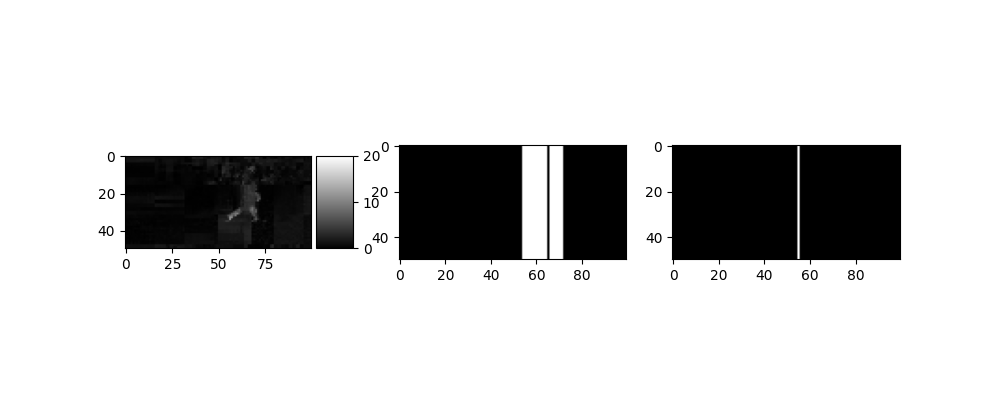

In [22]:
fig,ax = plt.subplots(1,3,figsize=(10, 4))
ax_handle = ax[0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)

ax[1].imshow(areas_of_interest_cont,cmap="gray")
ax[2].imshow(y_line_estimates[1],cmap="gray",vmin=0, vmax=1)

Let us have a look at the intensitiy profile for a region (or line) of interest

In [23]:
line_mask = y_line_estimates[2]

In [24]:
x_non_zero = np.nonzero(np.any(line_mask != 0, axis=0))[0][-1]

A pedestrian may be modelled with a cylinder, which projection on a 2D plane can be approximated/calculated.
We assume pedestrians are upright and start with a index function that identifies lines in y-direction with changinge consequent pixels. 

<IPython.core.display.Javascript object>


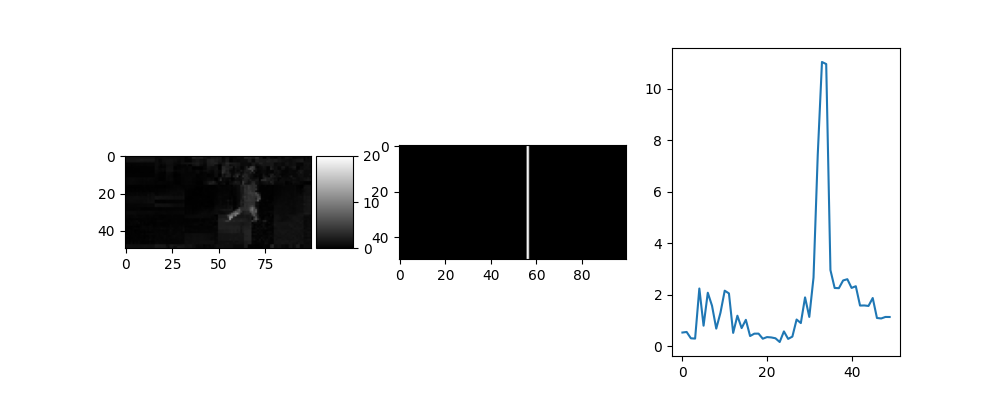

In [28]:
fig,ax = plt.subplots(1,3,figsize=(10, 4))
ax_handle = ax[0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)

ax[1].imshow(line_mask,cmap="gray")
ax[2].plot(d2_frame[:,x_non_zero])


Features for the location estimation of pedestrian should rely on assumption you can make on the shape of the objects of interests

Let us get the active pixels orthogonal to the ones found in the y direction as ROI in x direction as well

In [29]:
#ToDo: with minumum settings thhis should be quite relaxed -> improve
def get_feature_est(img, y_line_estimates, threshold = 20, max_single_pix_thres = 2, median_pix_thres = 0.3, min_width=2, max_width=20):  # this is the region of interest algorithm
    """Get cylinder shaped projection estimates in 2D"""
    ny_pix = img.shape[0]
    nx_pix = img.shape[1]
    ped_cylinder_estimates = []
    
    for y_line_m in y_line_estimates: 
        x_non_zero = np.nonzero(np.any(y_line_m != 0, axis=0))[0][-1]
        ped_cylinder_est = np.zeros(img.shape)
        
        #print (x_non_zero)
        for j in range(ny_pix):
            y1=j;y2=j+1
            if y_line_m[y1:y2,x_non_zero] == 1:
                 
                for width_guess in range(min_width, max_width):
                
                    ROI_2 = img[y1:y2, x_non_zero-int(width_guess/2):int(width_guess/2)+x_non_zero-1] 
                    d2_sum = ROI_2.flatten().sum()
                    
                    if len(ROI_2.flatten()) > 0:
                        max_d2 = max(ROI_2.flatten())
                        median_d2 =np.median(ROI_2.flatten())
                    else:
                        max_d2 = 0
                        mean_d2 = 0

                    if d2_sum > threshold and max_d2 > max_single_pix_thres and median_d2 > median_pix_thres: 

                        ped_cylinder_est[y1:y2, x_non_zero-int(width_guess/2):x_non_zero+int(width_guess/2)] = 1
                
                
        if np.sum(ped_cylinder_est) > 0:           
            ped_cylinder_estimates.append(ped_cylinder_est)
            
    return ped_cylinder_estimates
        

In [30]:
ped_cylinder_estimates = get_feature_est(d2_frame,y_line_estimates, threshold = 10, max_single_pix_thres = 4, median_pix_thres = 2, min_width=1, max_width=15)

<IPython.core.display.Javascript object>


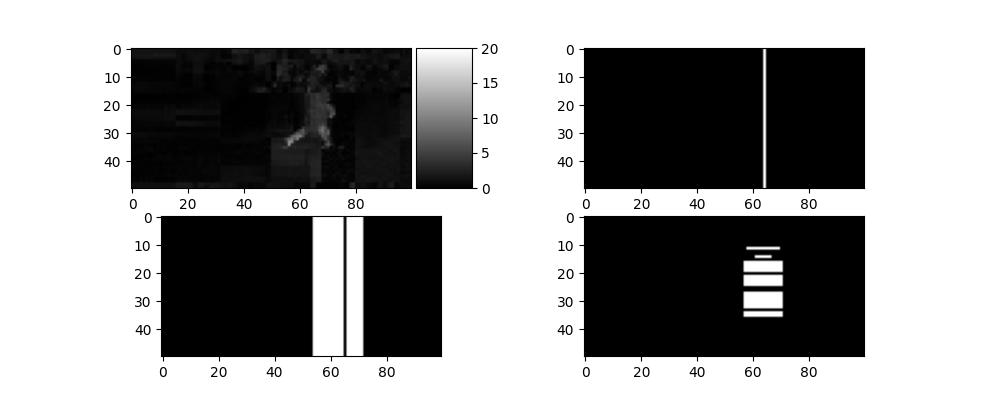

In [33]:
fig,ax = plt.subplots(2,2,figsize=(10, 4))
ax_handle = ax[0][0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)

ax[1][0].imshow(areas_of_interest_cont,cmap="gray",vmin=0, vmax=1)

n_est = 10

ax[0][1].imshow(y_line_estimates[n_est],cmap="gray",vmin=0, vmax=1)

ax[1][1].imshow(ped_cylinder_estimates[n_est],cmap="gray",vmin=0, vmax=1)

Now we have all ingredients to generate hypotheses, test and compare them. So generate hypotheses we start with our inductive bias on the system. We need to find a model that approximated persons to the extent, that they can be detected within this modality.

Pedestrians can be approximated as 3D cylinder objects for this purpose; 3D Zylinder objects can be described by 3 parameters: a height $H_p$, a Radius $R_p$ and a foot position estimation $LOC_{foot} =\begin{pmatrix} x_{foot} & y_{foot} & z_{foot}  \end{pmatrix}$ 


Let us try to get an estimate on the foot and the height in 2D image space, $x_{foot,2D}$ and  $y_{foot,2D}$,  $H_{p,2D}$, (note the different (projected)coordinate system.) 

Quick and dirty solution: Let us simply get the minimum and the maxium for all your active areas we estimated and splot the outcome.

In [34]:

foot_head_est_y = [np.where(np.any(ped, axis=1))[0][[0, -1]]  for ped in ped_cylinder_estimates]

In [35]:
foot_head_est_x = [np.nonzero(np.any(y_line_m != 0, axis=0))[0][-1] for y_line_m in  y_line_estimates]

In [36]:
head_pos = [f[0] for f  in foot_head_est_y]

In [37]:
foot_pos = [f[1] for f  in foot_head_est_y]

<IPython.core.display.Javascript object>


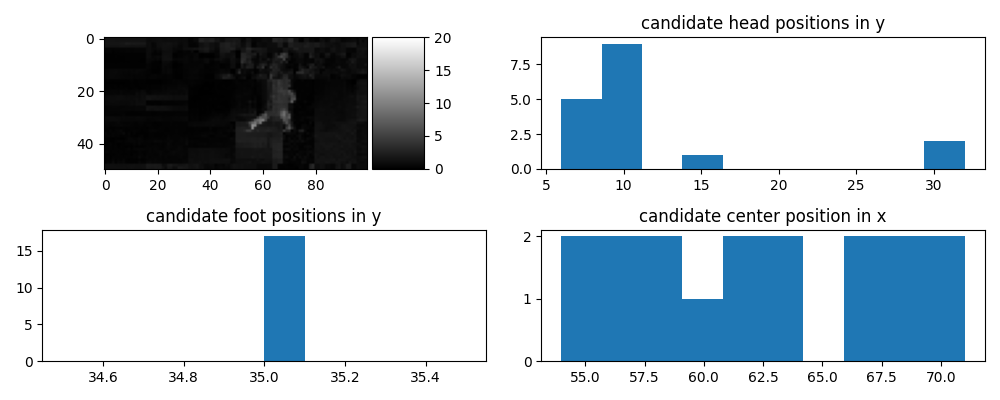

In [38]:
fig,ax = plt.subplots(2,2,figsize=(10, 4))
ax_handle = ax[0][0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)
ax[1][0].set_title("candidate foot positions in y")
ax[1][0].hist(foot_pos)

ax[0][1].set_title("candidate head positions in y")
ax[0][1].hist(head_pos)
ax[1][1].set_title("candidate center position in x")
ax[1][1].hist(foot_head_est_x)
plt.tight_layout()

Seems to make sense, but what is the most probable value for the foot position? Should we pick one of these values, take the mean or what? Answer: Switch into the world of probabilities. Formulate hypotheses on the foot position, test them and pick the estimate with the smallest uncertainty attached to it. 

Let us guess a probability function for the foot position. Maybe it is x=50, and y=25 with a variance of 1 for each estimate and statistically independent(a totally random guess with having seen any data). The prior probability function for the foot positions is thus $G(x,y)(\mu_{foot}, cov(\mu_{foot}))$, a 2-dimensional gaussian distribution with exppectation values for the mean $\mu_{foot}$ = (50, 25) and co-variance matrix $cov(\mu_{foot})$. Remember that for a one dimensional gaussian distrbution a mean and a variance are defining the distribution.

In [39]:

gaussian = torch.distributions.MultivariateNormal( torch.tensor([50., 25]),torch.eye(2))


https://pytorch.org/docs/stable/distributions.html
    
Bases: torch.distributions.distribution.Distribution

Creates a multivariate normal (also called Gaussian) distribution parameterized by a mean vector and a covariance matrix.

The multivariate normal distribution can be parameterized either in terms of a positive definite covariance matrix \mathbf{\Sigma}Σ or a positive definite precision matrix \mathbf{\Sigma}^{-1}Σ 
−1
  or a lower-triangular matrix \mathbf{L}L with positive-valued diagonal entries, such that \mathbf{\Sigma} = \mathbf{L}\mathbf{L}^\topΣ=LL 
⊤
  . This triangular matrix can be obtained via e.g. Cholesky decomposition of the covariance.



In [40]:
data = gaussian.sample_n(10000)

/home/pi/.local/lib/python3.8/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [41]:
x = [d.numpy().data[0] for d in data]

In [42]:
y = [d.numpy().data[1] for d in data]

<IPython.core.display.Javascript object>


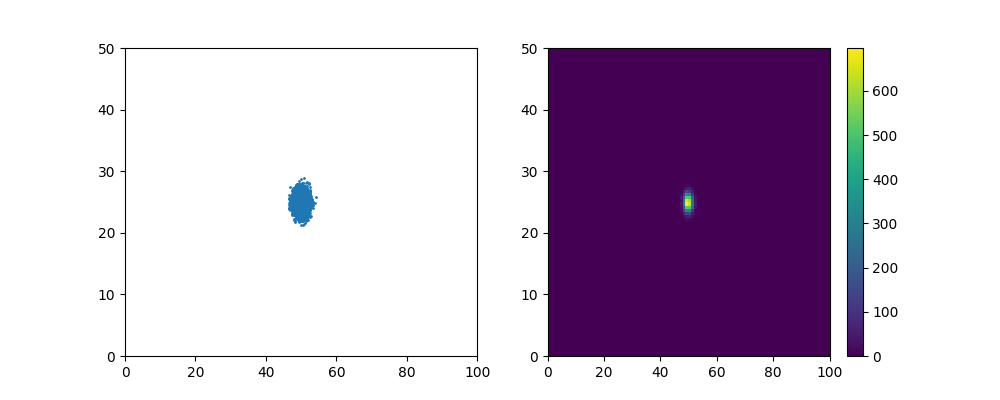

In [43]:
fig,ax = plt.subplots(1,2,figsize=(10, 4))
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 50)


r = [[0, 100], [0, 50]]               
ax[0].scatter(x,y,s=1)

ax_handle = ax[1].hist2d(x,y,range = r,bins=100)
fig.colorbar(ax_handle[3], ax=ax[1])




 Let $P(x_{foot,2D},y_{foot,2D}| m )$ be the posterior probability to be maximised and m be the measurements of $d2_{x,y}$ orthogonal to the ROIs (see get_active_areas()).

$P(x_{foot,2D},y_{foot,2D}| m ) = P(x^b_{foot,2D},y^b_{foot,2D}| m^b )* P(x^o_{foot,2D},y^o_{foot,2D}| m^o )  $  with b denoting background and o denoting the object (here a pedestrian)

$= P(x^b_{foot,2D},y^b_{foot,2D}| m^b )*(1-P('x^o_{foot,2D},'y^o_{foot,2D}| m^o ))$

Let us use Bayes theorem to decompose the posteroir probability further

$= \frac{ p(m^b | x^b_{foot,2D},y^b_{foot,2D})*P(x^b_{foot,2D},y^b_{foot,2D}) }{p(m^b)} *\frac{p(m^o)-p(m^o|'x^o_{foot,2D},'y^o_{foot,2D})*P('x^o_{foot,2D},'y^o_{foot,2D}))}{p(m^o)} $  with p denoting the probability density functions

We can see that $P(x_{foot,2D},y_{foot,2D}| m )$ becomes maximal for maximal $p(m^b | x^b_{foot,2D},y^b_{foot,2D})$ and minimal $p(m^o|'x^o_{foot,2D},'y^o_{foot,2D})$ 

We conclude that the best foot position should be at $x^{max}_{foot,2D},y^{max}_{foot,2D} = argmin_{x,y} log (\frac{p(m^o|'x^o_{foot,2D},'y^o_{foot,2D})}{p(m^b | x^b_{foot,2D},y^b_{foot,2D})})$

If we assume that the $m^o$ and $m^b$ are both following a gaussian distribution with same variance we can approximate 


$log (\frac{p(m^o|'x^o_{foot,2D},'y^o_{foot,2D})}{p(m^b | x^b_{foot,2D},y^b_{foot,2D})}) = \sum^{y_{foot}-1}_{y=0} d2_{x,y} + \sum^{y_{maximum}}_{y=y_{height}} d2_{x,y}  - \sum^{y_{height}-1}_{y=y_{foot}} d2_{x,y} $ with $x_{foot}$ being he candidate for the foot position in x direction

$ \sum^{y_{foot}-1}_{y=0} d2_{x,y}$ is the sum of the d2 values from the minimum in x to the potential foot position
$\sum^{y_{maximum}}_{y=y_{height}} d2_{x,y}$ is the sum of the d2 values from the potential head position to the maximum in x and $\sum^{y_{height}-1}_{y=y_{foot}} d2_{x,y}$ is the sum of values between head and foot

In [44]:
ped_est = ped_cylinder_estimates[2]

In [45]:
idx=(ped_est==1)
ped_est[idx]=d2_frame[idx]

In [46]:
ped_est.flatten()

array([0., 0., 0., ..., 0., 0., 0.])

In [47]:
d2_frame.shape

(50, 100)

In [52]:
def get_posterior_approx(ped_est, d2_frame, y_cand, height_cand):
    
    idx=(ped_est==1) # get mask for d2_x,y values orthiginal to y
    ped_est[idx]=d2_frame[idx] # replace 1 with real values in mask
    y_bins = d2_frame.shape[0]
    
    #Since the coordinate system start in y direction at 0, we have to invert the search
    foot_cand = y_bins-y_cand
    head_cand = y_bins-y_cand- height_cand
    #print("y_cand from below",y_cand,"foot_cand on img",foot_cand,"head_cand on img",head_cand)
    
    term1 = np.sum(ped_est[foot_cand:y_bins,:]) # foot position candidate to the botton
    term2 = np.sum(ped_est[0:head_cand,:])# head position candidate to the top
    term3 = np.sum(ped_est[head_cand:foot_cand,:]) # foot to head position candidate
    #print (term1,term2,-term3)
    return term1 + term2 - term3,(term1,term2,-term3)

In [53]:
n_est = 10

In [54]:
estimator_posterior = get_posterior_approx(ped_cylinder_estimates[n_est],d2_frame, 0, 35)

In [55]:
est_post = [ get_posterior_approx(ped_cylinder_estimates[n_est],d2_frame, y_cand, 20) for y_cand in range(d2_frame.shape[0],0,-1)]

In [56]:
line_mask = y_line_estimates[n_est]
x_non_zero = np.nonzero(np.any(line_mask != 0, axis=0))[0][-1]

<IPython.core.display.Javascript object>


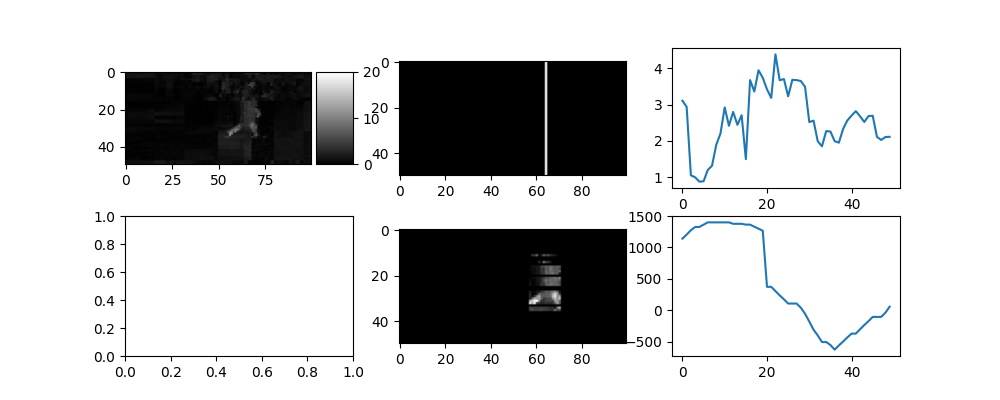

In [57]:
fig,ax = plt.subplots(2,3,figsize=(10, 4))
ax_handle = ax[0][0].imshow(d2_frame,cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)
ax[0][1].imshow(y_line_estimates[n_est],cmap="gray")
ax[1][1].imshow(ped_cylinder_estimates[n_est],cmap="gray")
ax[0][2].plot(d2_frame[:,x_non_zero])
ax[1][2].plot([p[0] for p in est_post])